In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection

### Test avec des réseaux de neurones

Nous allons préparer notre dataset pour travailler avec des réseaux de neurones. Nous allons effectuer le même traitement des données qu'avec xgBoost mais avec une normalisation.

1. Enlève les vecteur avec des NaN dans les colones Age, Height, Weight
2. Filtre les valeurs abérente
3. On encode le Sex et le type de sport (équie, individuel)
4. On construit un test set et un train set
5. On normalise les jeux de données



In [132]:
# Charge les données
df_events = pd.read_csv("athlete_events.csv", index_col='ID')
df_events.head()

# Supprimer les vecteurs ou il manque des valeurs et supprime les valeurs abérante
df_events.dropna(inplace=True, subset=['Age', 'Height', 'Weight'])
df_events = df_events[(df_events['Age'] < 85) & (df_events['Weight'] < 200)]

# Supprimer les colonles inutiles
X = df_events.drop(['Name', 'NOC', 'Games', 'Year', 'Season', 'City', 'Event', 'Sport', 'Team', 'Medal'], axis=1)
Y = df_events['Sport']
       
# Encode le Sex
label_encoder_sex = LabelEncoder()
X['Sex'] = label_encoder_sex.fit_transform(X['Sex'])

# Encode le Sport
sports = df_events.Sport.values.tolist()                                    # get sport value
sports = list(dict.fromkeys(sports))                                        # delete doublons 
sport_dictionary = dict.fromkeys(sports, 0)                                 # tranform to dict

def sport_to_group(sport):
    return {
     'Basketball': 1,
     'Judo': 0,
     'Football': 1,
     'Tug-Of-War': 1,
     'Speed Skating': 0,
     'Cross Country Skiing': 0,
     'Athletics': 0,
     'Ice Hockey': 1,
     'Swimming': 0,
     'Badminton': 0,
     'Sailing': 1,
     'Biathlon': 0,
     'Gymnastics': 0,
     'Art Competitions': 0,
     'Alpine Skiing': 0,
     'Handball': 1,
     'Weightlifting': 0,
     'Wrestling': 0,
     'Luge': 0,
     'Water Polo': 1,
     'Hockey': 1,
     'Rowing': 1,
     'Bobsleigh': 1,
     'Fencing': 0,
     'Equestrianism': 0,
     'Shooting': 0,
     'Boxing': 0,
     'Taekwondo': 0,
     'Cycling': 0,
     'Diving': 0,
     'Canoeing': 0,
     'Tennis': 0,
     'Modern Pentathlon': 0,
     'Figure Skating': 0,
     'Golf': 0,
     'Softball': 1,
     'Archery': 0,
     'Volleyball': 1,
     'Synchronized Swimming': 1,
     'Table Tennis': 0,
     'Nordic Combined': 0,
     'Baseball': 1,
     'Rhythmic Gymnastics': 0,
     'Freestyle Skiing': 0,
     'Rugby Sevens': 1,
     'Trampolining': 0,
     'Beach Volleyball': 1,
     'Triathlon': 0,
     'Ski Jumping': 0,
     'Curling': 1,
     'Snowboarding': 0,
     'Rugby': 1,
     'Short Track Speed Skating': 0,
     'Skeleton': 0,
     'Lacrosse': 1,
     'Polo': 1,
     'Cricket': 1,
     'Racquets': 0,
     'Motorboating': 0,
     'Military Ski Patrol': 0,
     'Croquet': 0,
     'Jeu De Paume': 0,
     'Roque': 0,
     'Alpinism': 0,
     'Basque Pelota': 1,
     'Aeronautics': 0
    }[sport]


# On encode le sport
Y = Y.apply(sport_to_group)

# Prépare le test set et le train set
X_train, X_test, Y_train_lb, Y_test_lb = train_test_split(X, Y, test_size=0.3, random_state=34)

# Augmente la précision pour le réseau de neurone 
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# On normalise les dataset
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Une fois que nos données ont été néttoyées et normalisées nous créons notre premier model et la façon de l'entrainer. Nous avons pris des valeurs aléatoires pour commencer à construire notre réseau.

In [138]:
# Une fonction pour définir le modèle
def model_def(input_dim, summary=False):
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', input_shape=(input_dim,)))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    if summary: model.summary()
    return model

# On construit une fonction réunissant les notions concernant l'apprentissage
def app_model(model, X_train, Y_train, X_test, Y_test, bc=64, e=50):
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=0, batch_size=bc, epochs=e, shuffle='True')
    return h

In [139]:
# On procède à l'entraînement !
start_time = time.time()

m = model_def(X_train.shape[1])
history = app_model(m, X_train, Y_train_lb, X_test, Y_test_lb)
print("--- %s seconds ---" % (time.time() - start_time))

--- 202.55333924293518 seconds ---


In [122]:
# On procède à l'évaluation
score = m.evaluate(X_test, Y_test_lb, verbose=0)
print('Test rmse: ', np.sqrt(score[0]))
print('Test mae: ', score[1])

predicted_classes = np.vectorize(lambda x: 0 if x < 0.5 else 1)(m.predict(X_test))
accuracy = accuracy_score(Y_test_lb,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test_lb,predicted_classes))

Test rmse:  0.681262351282827
Test mae:  0.7926563024520874
Accuracy (%):  79.2656308105224
              precision    recall  f1-score   support

           0       0.80      0.98      0.88     48451
           1       0.60      0.13      0.22     13398

    accuracy                           0.79     61849
   macro avg       0.70      0.55      0.55     61849
weighted avg       0.76      0.79      0.74     61849



Pour un premier essais nous obtenons une bonne précision. Maintenant notre but principal est de trouver les meilleurs hyperparamètres. Pour cela, il nous faut visualiser nos derniers résultats.

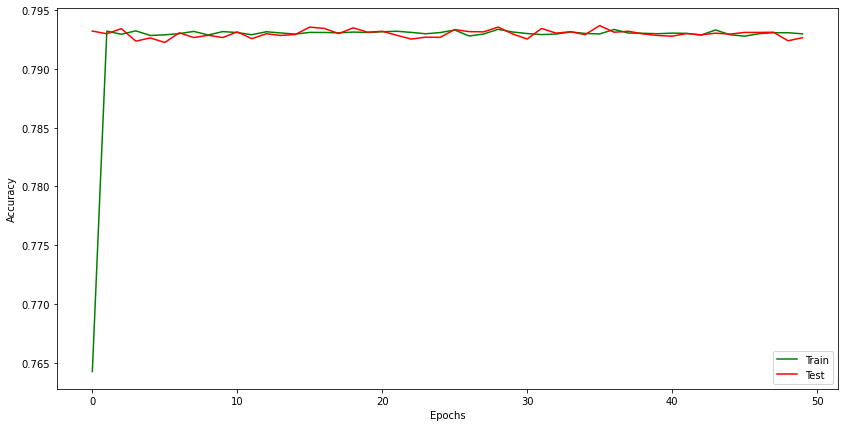

In [125]:
# On visualise l'apprentissage et le test
plt.figure(figsize=(14,7))
I = range(50)
plt.plot(I, history.history['accuracy'], color="green", label="Train")
plt.plot(I, history.history['val_accuracy'], color="red", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

On remarque tout de suite qu'au bout de 5 epoch il n'apprend plus rien, on va donc lui ajouter un early stopting pour lui dire que si il apprend plus rien au bout de 5 epoch, cela ne sert à rien de continuer.

In [136]:
# On construit une fonction réunissant les notions concernant l'apprentissage
def app_model(model, X_train, Y_train, X_test, Y_test, bc=64, e=50):
    h = model.fit(
        X_train, 
        Y_train, 
        validation_data=(X_test, Y_test), 
        verbose=0, 
        batch_size=bc, 
        epochs=e, 
        shuffle='True',
        callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
    )
    return h

### On passe de 3min a 19s de temps de calcule

- cela ne sert à rien de changer epoch car il converge très vite
- on peux test le batch maintenant

Nous avons deux options pour commencer qui consistent à agir sur 2 hyperparametre epoch et le batch. Vue que notre model converge très vite nous allons garder notre epoch à 50, en revanche, nous allons tester pour différentes valeures de batch le résultat.

In [137]:
# On procède à l'entraînement !
start_time = time.time()

m = model_def(X_train.shape[1])
history = app_model(m, X_train, Y_train_lb, X_test, Y_test_lb)

print("--- %s seconds ---" % (time.time() - start_time))

--- 18.92765760421753 seconds ---


Nous allons tester plusieurs batch possible.

In [54]:
preci = []
for i in range(6, 15):
  m = model_def(X_train.shape[1])
  history = app_model(m, X_train, Y_train_lb, X_test, Y_test_lb, bc=2**i)
  score = m.evaluate(X_test, Y_test_lb, verbose=0)
  predicted_classes = np.vectorize(lambda x: 0 if x < 0.5 else 1)(m.predict(X_test))
  accuracy = accuracy_score(Y_test_lb,predicted_classes)
  preci.append((2**i,accuracy * 100))

On remarque que entre 64 et 4096 batch il n'y pas grande différence de performance. Nous allons donc choisir 2096 car c'est lui qui a la plus garde précision. Il ne nous reste plus qu'a bien agencer nos neurones.



In [67]:
preci

[(64, 79.26239712849036),
 (128, 79.28988342576274),
 (256, 79.28503290271468),
 (512, 79.30120131287491),
 (1024, 79.25431292341024),
 (2048, 79.36102443046775),
 (4096, 79.27694869763457),
 (8192, 77.87353069572669),
 (16384, 77.21547640220537)]

Nous avons testé plusieurs configurations de neurones possibles, et nous n'avons pas trouvé d'agencement qui dépassais les 81%. Nous nous heurtons donc aux mêmes limites que avec la régression nous n'avons pas assez d'inforation sur les sportifs pour pouvoir trancher efficacement.

In [126]:
# Une fonction pour définir le modèle
def model_def(input_dim, summary=False):
    model = Sequential()
    model.add(Dense(8, activation='tanh', input_shape=(input_dim,)))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    if summary: model.summary()
    return model

In [127]:
# On procède à l'entraînement !
m = model_def(X_train.shape[1])
history = app_model(m, X_train, Y_train_lb, X_test, Y_test_lb)

In [129]:
score = m.evaluate(X_test, Y_test_lb, verbose=0)
print('Test rmse: ', np.sqrt(score[0]))
print('Test mae: ', score[1])

predicted_classes = np.vectorize(lambda x: 0 if x < 0.5 else 1)(m.predict(X_test))
accuracy = accuracy_score(Y_test_lb,predicted_classes)

print('Accuracy (%): ', accuracy * 100)

print(classification_report(Y_test_lb,predicted_classes))

Test rmse:  0.6577444317682403
Test mae:  0.8109427690505981
Accuracy (%):  81.09427799964429
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     48451
           1       0.69      0.23      0.35     13398

    accuracy                           0.81     61849
   macro avg       0.75      0.60      0.62     61849
weighted avg       0.79      0.81      0.77     61849



Nous pouvons constater que le réseau de neurones est légèrement moins pérformant qu'un model classique.